# Dartboard as an Object Function
### Seminar work on Heuristic Optimization
#### Author: Ales Suchomel
#### Year: 2020

#### WARNING! Re-running this notebook could take few hours...

### Introduction

This paper builds on [MMC seminar work (Czech)](files/sources/ales_suchomel_mmc_zapoctova_prace.pdf) that focused on problem definition, pseudo-random data generation and Monte-Carlo integration. Most of the theory, including domain explanation and derivation of the object function, is also already processed there with only one exception, the optimization itself. 

An interesting particle-flock based heuristic was used for that purpose, but its performance was not tested at all and it was used just as a black-box code implemented within Ondrej Panek's bachelor thesis. 

Therefore, the purpose of this paper is to complete the previous seminar work by finding the right heuristic for the optimization.

### Goals
The formal goal of this paper is to find a point to aim the dart at that ensures the highest expected score from a single throw. Thanks to an interesting structure of the dartboard, the optimal point is not always in the middle of the target but rather depends on the player's skills. The final output should be a graph of development of the best strategy depending on player's throw variance.

The real motivation for this theme is the possibility to test different heuristics at optimizing real-world-based non-trivial object function with local minima that is very easy to interpret. In other words, gain some experience with heuristics optimizing known function, so they can be trusted and successfully used at unknown later.

Moreover, the object function is parametric. If the player is one hundred percent accurate, the function is not continuous but contains several levels. In reality, there is some variance in player's throws and therefore, the shape of the function smooths to a mountain range like surface. An interesting question is how different heuristics will perform in both cases.

### Object Function
The object function represents the dartboard and player's skills. It is not generally continuous, it contains approximately 30 evenly distributed local minima, and is limited, see fig below. We do not generally know its optimal value, but we can determine it for some values of its parameters.

It is defined on 2-dimensional, limited, continuous area, but for optimization purposes it is possible to lay 1mm grid, as player is not able to aim more precisely and the peaks will not be that sharp. It would made possible to evaluate the object function in approximately 40 thousand points.

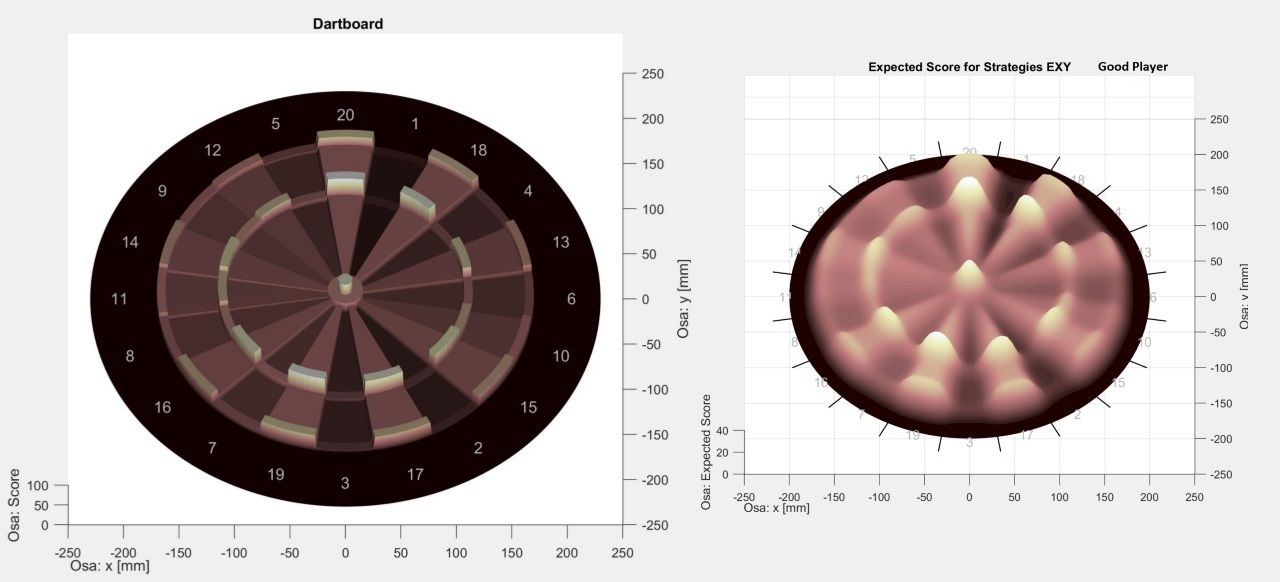

### Heuristic
Good results require chosen heuristic to successfully identify the right peak that contains the optimal value. So reliability is the key metric here. However, evaluation of the object function requires computing an integral using Monte-Carlo method, which is time consuming. So the heuristic must make do with as little object function evaluation as possible, otherwise the required parametric analysis would be very computationally demanding or impossible at all.

Requirements:
1. Reliability: over 90 %.
2. Number of Evaluation: less than 1000.

### Workflow Outline:
1. Rewriting my object functions from MATLAB to course-specific python interface
2. Rewriting my dartboard plotter from MATLAB to python
3. Implementing general object for simpler experimenting with different kinds of heuristics at ones
4. Experimenting with heuristics from this course framework without exploitation detailed information about object functions
   1. Testing heuristics on dartboard itself without tying the variance of the throw (left function on fig above)
   2. Specifying variance of a very good player, calculating optimal value of such object function (right function on fig above)
   3. Testing heuristics on just defined, smooth object function
   4. Comparing heuristic performances on both variants of the object function
5. Trying to improve performance of the most promising heuristic for the smooth case by hyperparameter tuning 
6. Using the tuned heuristic for parametric analysis of optimal darts strategy
7. Discussing the results

### Imports

In [1]:
# Import path to source directory
import sys
import os
pwd = %pwd
sys.path.append(os.path.join(pwd, os.path.join('..','..', 'src')))

# Ensure modules are reloaded on any change
%load_ext autoreload
%autoreload 2

In [26]:
# Import extrenal libraries
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from IPython.display import clear_output

import matplotlib
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Import tool for convinient experimenting
from experimenting import ExperimentPerformer

In [4]:
# Import object functions
from objfun_darts import Dartboard, DartsAvgScore
from objfun_darts import DartsPlotter

In [5]:
# Import all available heuristics
from heur_aux import CauchyMutation, Correction, MirrorCorrection, ExtensionCorrection
from heur_sg import ShootAndGo
from heur_fsa import FastSimulatedAnnealing
from heur_de import DifferentialEvolution
from heur_go import GeneticOptimization
from heur_go import Crossover, UniformMultipoint, RandomCombination

In [6]:
# Setting external libraries
sns.set()
pd.set_option('display.max_rows', 50)

### Definition of an overview experiment

In [7]:
def get_overview_mutation(of):
    overview_mutations = []
    for correction in [Correction(of), MirrorCorrection(of)]:
            for r in [0.1, 0.5, 0.75]:
                overview_mutations.append(CauchyMutation(r, correction=Correction(of)))
    return overview_mutations

In [8]:
def get_overview_heurs(of, maxeval, RD=True, FSA=True, DE=True, GO=True):
    overview_heurs = []

    if RD:
        for hmax in [0, 5, 10, 50, np.inf]:
            for RD in [False, True]:
                overview_heurs.append(ShootAndGo(of, maxeval=maxeval, hmax=hmax, random_descent=RD))
    if FSA:
        for T0 in [1e-10, 1e-2, 1, np.inf]:
            for mutation in get_overview_mutation(of):
                for n0 in [1, 2, 5]:
                    overview_heurs.append(FastSimulatedAnnealing(of, maxeval=maxeval, T0=T0, n0=n0, alpha=2, mutation=mutation))

    if DE:
        for N in [4, 10, 20]:
            for CR in [0.2, 0.5, 0.8]:
                for F in [0.5, 1, 2]:
                    overview_heurs.append(DifferentialEvolution(of, maxeval=maxeval, N=N, CR=CR, F=F))

    if GO:
        for mutation in get_overview_mutation(of):
            for crossover in [Crossover(), UniformMultipoint(1), RandomCombination()]:
                for N in [1, 2, 5, 10, 30, 100]:
                    for Tsel1 in [0.5, 1]:
                        overview_heurs.append(GeneticOptimization(of, maxeval, N=N, M=N*3, Tsel1=Tsel1, Tsel2=0.1, 
                                                                  mutation=mutation,
                                                                  crossover=crossover))   
    return overview_heurs

In [18]:
def run_experiment(of, performer, heurs, num_runs):
    results = performer.experiment(heurs, num_runs)
    print('Best performance:')
    display(performer.get_stats().head(25))
    print('Worst performance:')
    display(performer.get_stats().tail(25))
    return results

### Overview Experiments
#### Warning! Running "run_overview_experiment" for object function "avg_score" will take atleast an hour on PC.

In [19]:
NUM_RUNS = 20
MAX_EVAL = 1000

#### 1. Multilevel object function - Dartboard 

In [10]:
dartboard = Dartboard()
dartboard_performer = ExperimentPerformer('dartboard.log')

In [ ]:
overview_heurs = get_overview_heurs(dartboard, MAX_EVAL)

In [11]:
dartboard_results = run_experiment(dartboard, dartboard_performer, overview_heurs, NUM_RUNS)

HBox(children=(FloatProgress(value=0.0, description='Experiment progress', max=334.0, style=ProgressStyle(description_width='initial')), HTML(value='')))


Best performance:


,of,heur,maxeval,feo,mne,rel
12,dartboard,DE_N=20_CR=0.2_F=0.5,1000,297.562327,282.684211,0.950
184,dartboard,SG_RS_hmax=0,1000,281.256392,260.162162,0.925
18,dartboard,DE_N=20_CR=0_F=0.5,1000,187.345679,168.611111,0.900
19,dartboard,DE_N=20_CR=0_F=1,1000,259.382716,233.444444,0.900
13,dartboard,DE_N=20_CR=0.2_F=1,1000,343.765432,309.388889,0.900
17,dartboard,DE_N=20_CR=0.5_F=2,1000,425.121107,361.352941,0.850
15,dartboard,DE_N=20_CR=0.5_F=0.5,1000,325.467128,276.647059,0.850
16,dartboard,DE_N=20_CR=0.5_F=1,1000,309.218750,247.375000,0.800
14,dartboard,DE_N=20_CR=0.2_F=2,1000,520.859375,416.687500,0.800
21,dartboard,DE_N=20_CR=8_F=0.5,1000,361.066667,270.800000,0.750


Worst performance:


,of,heur,maxeval,feo,mne,rel
94,dartboard,GOmixcau_cor_r=0.5mix_N=5_M=15_T1=0.5_T2=0.1,1000,280.0,14.0,0.050
148,dartboard,GOunicau_cor_r=0.1uni_N=1_M=3_T1=0.5_T2=0.1,1000,14120.0,706.0,0.050
126,dartboard,GOrndcau_cor_r=0.5rnd_N=2_M=6_T1=0.5_T2=0.1,1000,7100.0,355.0,0.050
112,dartboard,GOrndcau_cor_r=0.1rnd_N=1_M=3_T1=0.5_T2=0.1,1000,2520.0,63.0,0.025
74,dartboard,GOmixcau_cor_r=0.1mix_N=10_M=30_T1=0.5_T2=0.1,1000,2520.0,63.0,0.025
41,dartboard,FSAcau_cor_r=0.1_T0=1_n0=5_alpha=2,1000,1200.0,30.0,0.025
42,dartboard,FSAcau_cor_r=0.1_T0=1e-10_n0=1_alpha=2,1000,37800.0,945.0,0.025
149,dartboard,GOunicau_cor_r=0.1uni_N=1_M=3_T1=1_T2=0.1,1000,4080.0,102.0,0.025
45,dartboard,FSAcau_cor_r=0.1_T0=inf_n0=1_alpha=2,1000,8840.0,221.0,0.025
47,dartboard,FSAcau_cor_r=0.1_T0=inf_n0=5_alpha=2,1000,40.0,1.0,0.025


#### 2. Smooth object function - Average Score

In [12]:
avg_score = DartsAvgScore(7)  # 7mm... Superhuman trow variance
avg_score.fstar = -52.5  # Only peek at triple 20 reaches greater values
score_performer = ExperimentPerformer('avg_score.log')

In [ ]:
overview_score_heurs = get_overview_heurs(avg_score, MAX_EVAL)

In [13]:
score_results = run_experiment(avg_score, score_performer, overview_score_heurs, NUM_RUNS)

HBox(children=(FloatProgress(value=0.0, description='Experiment progress', max=334.0, style=ProgressStyle(description_width='initial')), HTML(value='')))


Best performance:


,of,heur,maxeval,feo,mne,rel
13,dartsscore,DE_N=20_CR=0.2_F=1,1000,438.311111,328.733333,0.750
15,dartsscore,DE_N=20_CR=0.5_F=0.5,1000,446.488889,334.866667,0.750
0,dartsscore,DE_N=10_CR=0.2_F=0.5,1000,494.693878,346.285714,0.700
16,dartsscore,DE_N=20_CR=0.5_F=1,1000,969.861111,581.916667,0.600
184,dartsscore,SG_RS_hmax=0,1000,720.378072,414.217391,0.575
7,dartsscore,DE_N=10_CR=0_F=1,1000,565.400000,282.700000,0.500
22,dartsscore,DE_N=20_CR=8_F=1,1000,487.000000,243.500000,0.500
21,dartsscore,DE_N=20_CR=8_F=0.5,1000,611.000000,305.500000,0.500
19,dartsscore,DE_N=20_CR=0_F=1,1000,745.800000,372.900000,0.500
5,dartsscore,DE_N=10_CR=0.5_F=2,1000,1270.617284,571.777778,0.450


Worst performance:


,of,heur,maxeval,feo,mne,rel
117,dartsscore,GOrndcau_cor_r=0.1rnd_N=30_M=90_T1=1_T2=0.1,1000,2350.0,117.5,0.050
45,dartsscore,FSAcau_cor_r=0.1_T0=inf_n0=1_alpha=2,1000,13280.0,664.0,0.050
69,dartsscore,FSAcau_cor_r=0.75_T0=inf_n0=1_alpha=2,1000,15710.0,785.5,0.050
123,dartsscore,GOrndcau_cor_r=0.5rnd_N=10_M=30_T1=1_T2=0.1,1000,590.0,29.5,0.050
43,dartsscore,FSAcau_cor_r=0.1_T0=1e-10_n0=2_alpha=2,1000,12160.0,608.0,0.050
42,dartsscore,FSAcau_cor_r=0.1_T0=1e-10_n0=1_alpha=2,1000,8580.0,429.0,0.050
81,dartsscore,GOmixcau_cor_r=0.1mix_N=30_M=90_T1=1_T2=0.1,1000,1640.0,41.0,0.025
154,dartsscore,GOunicau_cor_r=0.1uni_N=5_M=15_T1=0.5_T2=0.1,1000,16840.0,421.0,0.025
127,dartsscore,GOrndcau_cor_r=0.5rnd_N=2_M=6_T1=1_T2=0.1,1000,15000.0,375.0,0.025
58,dartsscore,FSAcau_cor_r=0.5_T0=inf_n0=2_alpha=2,1000,4560.0,114.0,0.025


#### Performance Evaluation
Generic methods and simulated annealing turned out badly for all tested parameters. Intuitively, it does not make much sense to mutate or crossover coordinates of 2D surface points and hope it will identify the right peak. But the main reason could be the value of Couchy Mutation parameter "r", that was set to value lower than 1 in all cases. It results into many small steps that probably wasted precious evaluations.  

Due to the relatively large area with the optimal value, Random Shooting was very successful. As expected, it performed better than the other local-gradient-based Shoot and Go methods during optimizing the plane Dartboard object function. However, it is a bit disappointing that this was also the case in the second version of the object function. Better results from Random and Steepest descent were expected there. Perhaps if neighborhood was defined differently (larger and thinner), the results could be better.

The only heuristic that could compete with Random Shooting in reliability is Differential Evolution. This algorithm was absolutely the worst with a small population, but larger value of the parameter N improved significantly its performance. The effects of the other parameters are not clear yet. The reason for the success of the algorithm will probably be an even initial distribution of its agents (Random Shooting) and relatively large jumps that the points can make in one iteration.

Altogether, the results of the initial tests are not entirely encouraging. One of the two most successful methods is just randomly selecting points. Most sophisticated heuristics have burned out. The only hope seems to be to try to optimize the performance of Differential Evolution, but it seems that the main reason for this heuristic success is its similarity to Random Shooting.

### Corrections

#### Last chance for GO and FSA

In [20]:
def get_correction_mutation(of):
    correction_mutations = []
    for correction in [Correction(of), MirrorCorrection(of)]:
            for r in [1, 1.5, 2, 5]:
                correction_mutations.append(CauchyMutation(r, correction=Correction(of)))
    return correction_mutations

In [21]:
def get_correction_heurs(of, maxeval, FSA=True, GO=True):
    overview_heurs = []

    if FSA:
        for T0 in [1e-10, 1e-2, 1, np.inf]:
            for mutation in get_correction_mutation(of):
                for n0 in [1, 2, 5]:
                    overview_heurs.append(FastSimulatedAnnealing(of, maxeval=maxeval, T0=T0, n0=n0, alpha=2, mutation=mutation))
    if GO:
        for mutation in get_correction_mutation(of):
            for crossover in [UniformMultipoint(1)]:
                for N in [100, 150, 200]:
                    for Tsel1 in [0.5]:
                        overview_heurs.append(GeneticOptimization(of, maxeval, N=N, M=N*3, Tsel1=Tsel1, Tsel2=0.1, 
                                                                  mutation=mutation,
                                                                  crossover=crossover))   
    return overview_heurs

In [22]:
correction_heurs = get_correction_heurs(avg_score, MAX_EVAL)

In [24]:
correction_results = run_experiment(avg_score, score_performer, correction_heurs, NUM_RUNS)

HBox(children=(FloatProgress(value=0.0, description='Experiment progress', max=120.0, style=ProgressStyle(description_width='initial')), HTML(value='')))


Best performance:


,of,heur,maxeval,feo,mne,rel
15,dartsscore,DE_N=20_CR=0.5_F=0.5,1000,446.488889,334.866667,0.750
13,dartsscore,DE_N=20_CR=0.2_F=1,1000,438.311111,328.733333,0.750
0,dartsscore,DE_N=10_CR=0.2_F=0.5,1000,494.693878,346.285714,0.700
16,dartsscore,DE_N=20_CR=0.5_F=1,1000,969.861111,581.916667,0.600
244,dartsscore,SG_RS_hmax=0,1000,720.378072,414.217391,0.575
22,dartsscore,DE_N=20_CR=8_F=1,1000,487.000000,243.500000,0.500
21,dartsscore,DE_N=20_CR=8_F=0.5,1000,611.000000,305.500000,0.500
19,dartsscore,DE_N=20_CR=0_F=1,1000,745.800000,372.900000,0.500
7,dartsscore,DE_N=10_CR=0_F=1,1000,565.400000,282.700000,0.500
238,dartsscore,GOunicau_cor_r=5uni_N=150_M=450_T1=0.5_T2=0.1,1000,935.955679,444.578947,0.475


Worst performance:


,of,heur,maxeval,feo,mne,rel
59,dartsscore,FSAcau_cor_r=0.5_T0=inf_n0=5_alpha=2,1000,11790.0,589.5,0.050
171,dartsscore,GOrndcau_cor_r=0.5rnd_N=10_M=30_T1=1_T2=0.1,1000,590.0,29.5,0.050
165,dartsscore,GOrndcau_cor_r=0.1rnd_N=30_M=90_T1=1_T2=0.1,1000,2350.0,117.5,0.050
105,dartsscore,FSAcau_cor_r=2_T0=inf_n0=1_alpha=2,1000,9450.0,472.5,0.050
143,dartsscore,GOmixcau_cor_r=0.5mix_N=5_M=15_T1=1_T2=0.1,1000,2320.0,116.0,0.050
197,dartsscore,GOunicau_cor_r=0.1uni_N=1_M=3_T1=1_T2=0.1,1000,9200.0,230.0,0.025
130,dartsscore,GOmixcau_cor_r=0.1mix_N=5_M=15_T1=0.5_T2=0.1,1000,160.0,4.0,0.025
129,dartsscore,GOmixcau_cor_r=0.1mix_N=30_M=90_T1=1_T2=0.1,1000,1640.0,41.0,0.025
47,dartsscore,FSAcau_cor_r=0.1_T0=inf_n0=5_alpha=2,1000,38920.0,973.0,0.025
202,dartsscore,GOunicau_cor_r=0.1uni_N=5_M=15_T1=0.5_T2=0.1,1000,16840.0,421.0,0.025


#### Evaluation
No major improvement was observed after the expansion of the parameter space of heuristics GO and FSA. Tuning DE is still the only hope for the successful fulfillment of the formal goal of the work.

#### Tuning Differential Evolution

#### 1. Parameter Space Expansion

In [40]:
def get_de_results_for_tuning(of, performer, num_runs, maxeval):
    results = pd.DataFrame()
    
    for N in [10, 15, 20, 25, 50]:
        for CR in [0, 0.2, 0.4, 0.6, 0.8, 1]:
            for F in [0.1, 0.5, 1, 1.5, 2]:
                heur = DifferentialEvolution(of, maxeval=maxeval, N=N, CR=CR, F=F)
                result = performer.experiment(heur, num_runs)
                clear_output(wait=True)
                result['N'] = N
                result['CR'] = CR
                result['F'] = F
                results = pd.concat([results, result], axis=0)
    return results

In [41]:
table = get_de_results_for_tuning(avg_score, score_performer, NUM_RUNS, MAX_EVAL)
display(table)
table.to_csv('de_tuning.log', header=True)

,of,heur,run,best_x,best_y,maxeval,neval,N,CR,F
0,dartsscore,DE_N=10_CR=0_F=0.1,10539,"[0.0921977299999992, -0.05012000000000005]",[-48.685],1000,inf,10,0.0,0.1
1,dartsscore,DE_N=10_CR=0_F=0.1,10540,"[1.3402492358000018, -0.5889062746999997]",[-48.04],1000,inf,10,0.0,0.1
2,dartsscore,DE_N=10_CR=0_F=0.1,10541,"[0.20537499999999864, 0.15722544760000232]",[-48.6825],1000,inf,10,0.0,0.1
3,dartsscore,DE_N=10_CR=0_F=0.1,10542,"[0.09630103378950292, -0.005282417731516033]",[-48.685],1000,inf,10,0.0,0.1
4,dartsscore,DE_N=10_CR=0_F=0.1,10543,"[-0.02554391200000021, 0.0897442300000002]",[-48.64],1000,inf,10,0.0,0.1
...,...,...,...,...,...,...,...,...,...,...
15,dartsscore,DE_N=50_CR=1_F=2,13534,"[-1.1, -0.4]",[-48.1975],1000,inf,50,1.0,2.0
16,dartsscore,DE_N=50_CR=1_F=2,13535,"[-7.999999999999993, 113.00000000000001]",[-48.5495],1000,inf,50,1.0,2.0
17,dartsscore,DE_N=50_CR=1_F=2,13536,"[-0.5, 1.0]",[-48.1475],1000,inf,50,1.0,2.0
18,dartsscore,DE_N=50_CR=1_F=2,13537,"[70.7999999999998, 84.80000000000126]",[-49.0464],1000,inf,50,1.0,2.0


In [42]:
score_performer.get_stats().head(25)

,of,heur,maxeval,feo,mne,rel
63,dartsscore,DE_N=15_CR=0.4_F=1,1000,566.044444,424.533333,0.750
116,dartsscore,DE_N=20_CR=0.5_F=0.5,1000,446.488889,334.866667,0.750
213,dartsscore,DE_N=50_CR=0.6_F=0.5,1000,657.688889,493.266667,0.750
212,dartsscore,DE_N=50_CR=0.6_F=0.1,1000,455.111111,341.333333,0.750
120,dartsscore,DE_N=20_CR=0.6_F=0.5,1000,733.265306,513.285714,0.700
121,dartsscore,DE_N=20_CR=0.6_F=1,1000,583.265306,408.285714,0.700
163,dartsscore,DE_N=25_CR=0.2_F=1.5,1000,489.489796,342.642857,0.700
186,dartsscore,DE_N=25_CR=1_F=0.5,1000,495.408163,346.785714,0.700
202,dartsscore,DE_N=50_CR=0.2_F=0.1,1000,579.285714,405.500000,0.700
108,dartsscore,DE_N=20_CR=0.2_F=1,1000,502.441701,339.148148,0.675


#### Evaluation
The expansion of the parameter space indicated that a large population could indeed have a positive effect on performance. For other parameters, their influence is still not clear. However, CR values around 0.5 and F less than 1 seems to have the best results. Further research is needed.

#### 2. Parameter Analysis 

In [104]:
def analyze_parameter(table, param_name, value_name='best_y'):
    display(table.groupby(param_name).agg({value_name: ['mean', 'median','var', 'max']}))
    if not isinstance(param_name, list):
        plt.figure()
        sns.boxplot(x=param_name, y=value_name, data=table)

best_y                              
         mean    median        var      max
N                                          
10 -49.282035 -51.21150  32.128114 -19.9981
15 -50.886106 -52.00040  13.471899 -27.3435
20 -51.449181 -52.21410   9.127879 -33.1143
25 -51.606827 -52.24305   7.702509 -37.8118
50 -51.904521 -52.28190   6.207364 -40.4935

<IPython.core.display.Javascript object>


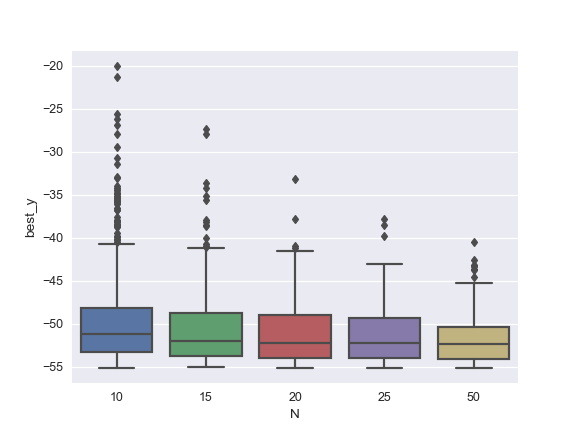

In [97]:
analyze_parameter(table, 'N')

These results for param N confirm the assumed fact that population growth has a positive effect on performance. However, the mean values for each population are quite small. It means other parameters do have significant effect. Further expansion of the parametric space, in order to find the optimal population is also necessary.

best_y                              
          mean    median        var      max
CR                                          
0.0 -51.887320 -52.23825   7.141313 -38.5000
0.2 -51.772606 -52.37070   9.241731 -34.9398
0.4 -51.667861 -52.29560   8.058485 -38.4972
0.6 -51.195717 -52.13550  10.358618 -34.4603
0.8 -50.546137 -51.85650  15.890592 -25.6332
1.0 -49.084763 -49.70570  31.181367 -19.9981

<IPython.core.display.Javascript object>


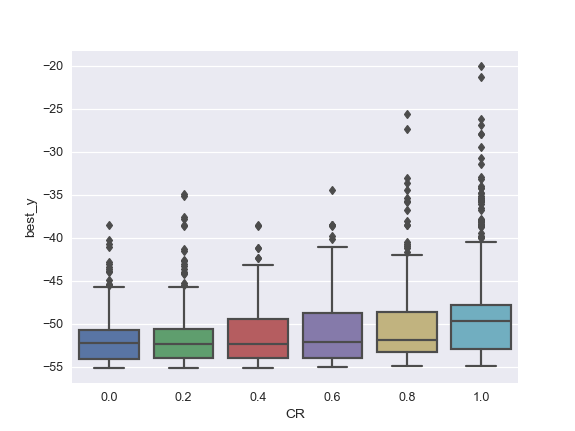

In [98]:
analyze_parameter(table, 'CR')

This is quite surprising. The best average results are for CR value 0, which is in conflict with overview experiments, during which the best places usually were taken by combinations with CR around 0.5. It is possible that these go better along larger populations. However, the values of the statistics for 0 are comparable to those for 0.4, which has even the highest median. However, following table can show the situation better.

In [109]:
analyze_parameter(table, ['CR', 'N'])

best_y                              
             mean    median        var      max
CR  N                                          
0.0 10 -51.277730 -52.02960  10.684064 -38.5000
    15 -51.698521 -52.11260   7.432631 -41.0280
    20 -52.301180 -52.74800   5.374027 -43.4098
    25 -52.029673 -52.85600   6.785287 -43.8112
    50 -52.129496 -52.36800   5.055017 -43.6600
0.2 10 -50.840482 -52.17210  17.740842 -34.9398
    15 -51.668765 -52.17400   7.575661 -38.5458
    20 -51.880931 -52.82950   9.128245 -37.8099
    25 -52.306857 -53.03775   5.579830 -44.0964
    50 -52.165997 -52.30865   5.212478 -42.6096
0.4 10 -51.411434 -52.26520   9.918195 -38.4972
    15 -51.211174 -52.31490  11.838399 -38.5577
    20 -51.581217 -52.16255   6.810007 -42.3840
    25 -51.995939 -52.39700   5.166520 -44.8300
    50 -52.139539 -52.63000   6.266775 -43.7344
0.6 10 -49.872089 -50.00330  18.622738 -34.4603
    15 -50.849120 -51.72900   9.316742 -42.1688
    20 -51.554629 -52.22340   8.032707 -42.4700
    25 -51.475320 -51.96430   6.584564 -44.7802
    50 -52.227426 -52.83625   6.479576 -43.1232
0.8 10 -48.276781 -49.40400  32.307093 -25.6332
    15 -50.628793 -52.18920  17.769235 -27.3435
    20 -51.189939 -52.26900   9.241506 -40.9260
    25 -50.998710 -51.53660   7.495927 -44.2625
    50 -51.636460 -52.02020   6.245975 -40.4935
1.0 10 -44.013693 -46.06875  64.653715 -19.9981
    15 -49.260265 -49.60510  23.448641 -27.9536
    20 -50.187191 -50.67700  14.014826 -33.1143
    25 -50.834462 -52.07700  13.169823 -37.8118
    50 -51.128206 -51.85900   7.335231 -43.2668

Small values of the CR parameter complement well with a medium-sized population, especially points (0, 20) and (0.2, 25) are interesting. Values around 0.5 again work well with a larger population. These combinations tend to be more reliable e.g. (0.4, 50), (0.6, 50).

best_y                             
          mean   median        var      max
F                                          
0.1 -49.997244 -49.5144  19.198429 -19.9981
0.5 -52.530082 -52.8760   5.465356 -34.7586
1.0 -51.460723 -52.3214  16.001833 -21.3252
1.5 -51.063228 -51.8732  11.002936 -35.1680
2.0 -50.077392 -50.9719  16.907504 -27.9536

<IPython.core.display.Javascript object>


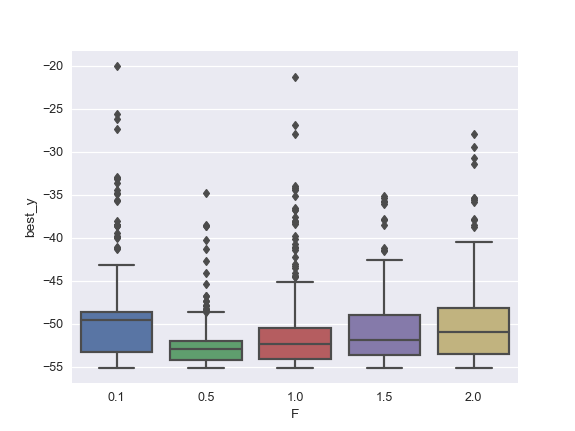

In [99]:
analyze_parameter(table, 'F')

In [106]:
analyze_parameter(table, ['F', 'N'])

best_y                              
             mean    median        var      max
F   N                                          
0.1 10 -46.748793 -48.54125  39.469561 -19.9981
    15 -49.415672 -48.68500  15.825371 -27.3435
    20 -50.458072 -49.55400  10.330043 -33.1143
    25 -51.011244 -52.05040   8.836393 -38.5308
    50 -52.352438 -52.64800   4.349395 -48.0150
0.5 10 -51.423187 -52.31840  14.128728 -34.7586
    15 -52.517219 -52.82200   4.301352 -46.7825
    20 -53.017588 -53.13325   2.435217 -47.9250
    25 -52.817118 -53.02300   2.657674 -47.7550
    50 -52.875298 -52.99150   2.308921 -47.3256
1.0 10 -48.568640 -51.01540  43.995064 -21.3252
    15 -51.568617 -52.24710  11.085601 -34.2361
    20 -52.818679 -53.08465   3.047638 -47.9556
    25 -52.121057 -52.64725   5.047995 -45.4490
    50 -52.226623 -52.61365   6.033791 -43.2600
1.5 10 -50.753722 -51.85480  18.349372 -35.3756
    15 -50.958585 -51.87080  11.789576 -35.1680
    20 -51.201535 -51.93110   8.823941 -41.5264
    25 -51.042298 -51.90610  10.401693 -37.8118
    50 -51.360003 -51.86620   5.803757 -43.1232
2.0 10 -48.915833 -50.51220  31.850984 -29.4373
    15 -49.970438 -50.82410  18.626672 -27.9536
    20 -49.750032 -49.29840  12.973750 -37.8099
    25 -51.042417 -51.63410   9.083624 -43.6050
    50 -50.708242 -51.16325   9.750238 -40.4935

For all possible population sizes, the optimal value for F seems to be 0.5. The neighborhood of this point should be further explored.

#### Parameters adjustment

In [112]:
def get_de_results_for_tuning_adjustment(of, performer, num_runs, maxeval):
    results = pd.DataFrame()
    
    for N in [30, 40, 60, 80, 100]:
        for CR in [0.4, 0.5, 0.6]:
            for F in [0.4, 0.5, 0.6]:
                heur = DifferentialEvolution(of, maxeval=maxeval, N=N, CR=CR, F=F)
                result = performer.experiment(heur, num_runs)
                clear_output(wait=True)
                result['N'] = N
                result['CR'] = CR
                result['F'] = F
                results = pd.concat([results, result], axis=0)
    return results

In [113]:
table_adj = get_de_results_for_tuning_adjustment(avg_score, score_performer, NUM_RUNS, MAX_EVAL)
table_adj.to_csv('de_tuning.log', mode='a', header=False)
table_adj['best_y'] = table_adj['best_y'].apply(lambda x: x[0])
all_table = pd.concat([table, table_adj], axis=0)
score_performer.get_stats().head(15)

,of,heur,maxeval,feo,mne,rel
202,dartsscore,DE_N=30_CR=0.5_F=0.4,1000,443.268698,421.105263,0.95
261,dartsscore,DE_N=60_CR=0.4_F=0.6,1000,421.038062,357.882353,0.85
200,dartsscore,DE_N=30_CR=0.4_F=0.5,1000,539.930796,458.941176,0.85
210,dartsscore,DE_N=40_CR=0.4_F=0.6,1000,661.953125,529.562500,0.80
8,dartsscore,DE_N=100_CR=0.6_F=0.6,1000,556.562500,445.250000,0.80
125,dartsscore,DE_N=20_CR=0.5_F=0.5,1000,446.488889,334.866667,0.75
201,dartsscore,DE_N=30_CR=0.4_F=0.6,1000,615.822222,461.866667,0.75
206,dartsscore,DE_N=30_CR=0.6_F=0.5,1000,556.177778,417.133333,0.75
207,dartsscore,DE_N=30_CR=0.6_F=0.6,1000,565.333333,424.000000,0.75
213,dartsscore,DE_N=40_CR=0.5_F=0.6,1000,600.800000,450.600000,0.75


Promising results have finally arrived. Especially the combination 30-0.5-0.4 looks very promising, but more runs are. However, it is necessary to perform additional tests on more runs.

#### Selecting the most promising variants

The following parameter analysis is intended to identify parameter combinations that will be further tested on a larger number of runs.

best_y                             
          mean    median       var      max
N                                          
30  -53.045900 -53.38400  2.901233 -44.3625
40  -52.889112 -53.37950  3.071392 -47.6175
60  -52.887522 -53.40965  2.847199 -47.7736
80  -52.690546 -53.19125  3.926825 -47.4675
100 -52.668861 -52.99350  3.802344 -42.6904

<IPython.core.display.Javascript object>


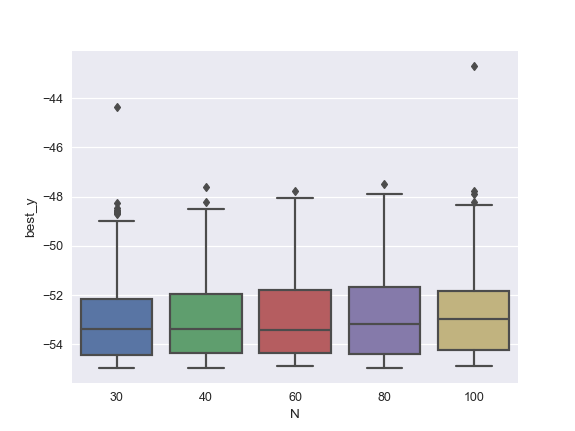

In [115]:
analyze_parameter(table_adj, 'N')

best_y                             
          mean    median       var      max
F                                          
0.4 -52.939143 -53.42600  2.917580 -47.4675
0.5 -52.649957 -53.00425  4.074115 -42.6904
0.6 -52.920065 -53.38000  2.922442 -47.9275

<IPython.core.display.Javascript object>


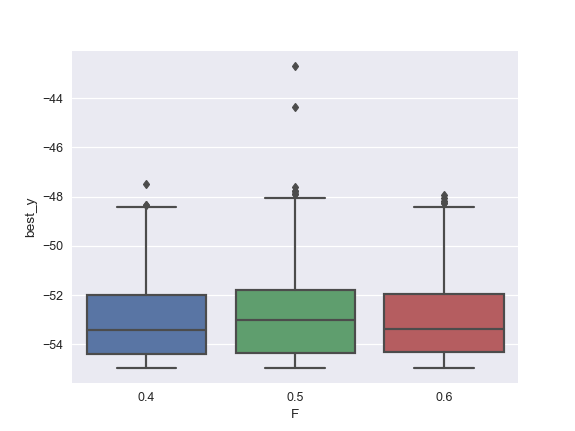

In [116]:
analyze_parameter(table_adj, 'F')

best_y                             
          mean    median       var      max
CR                                         
0.4 -52.812824 -53.39235  3.598120 -42.6904
0.5 -52.826832 -53.21025  3.235765 -47.4675
0.6 -52.869509 -53.21400  3.130994 -44.3625

<IPython.core.display.Javascript object>


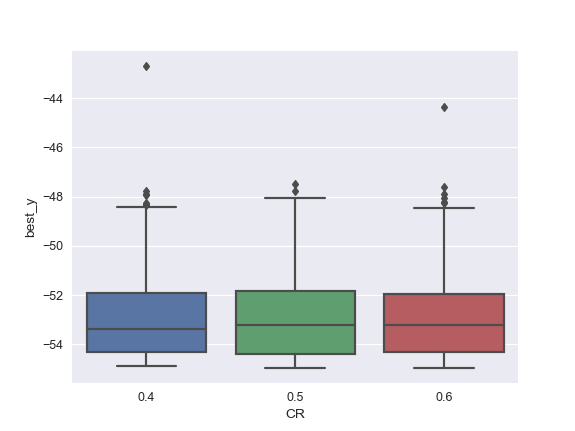

In [117]:
analyze_parameter(table_adj, 'CR')

#### Testing the most promising variants

In [118]:
def test_de_variant(of, performer, maxeval, N, CR, F, num_run):
    heur = DifferentialEvolution(of, maxeval=maxeval, N=N, CR=CR, F=F)
    result = performer.experiment(heur, num_runs)
    clear_output(wait=True)
    result['N'] = N
    result['CR'] = CR
    result['F'] = F
    return result

def test_most_promising_variants(of, performer, maxeval):
    num_runs = 100
    results = pd.DataFrame()
       
    results = pd.concat([results, test_de_variant(of, performer, maxeval, 20, 0, 0.5, num_run)], axis=0)
    results = pd.concat([results, test_de_variant(of, performer, maxeval, 20, 0.5, 0.5, num_run)], axis=0)
    results = pd.concat([results, test_de_variant(of, performer, maxeval, 25, 0.2, 0.5, num_run)], axis=0)
    results = pd.concat([results, test_de_variant(of, performer, maxeval, 30, 0.5, 0.4, num_run)], axis=0)
    results = pd.concat([results, test_de_variant(of, performer, maxeval, 30, 0.4, 0.5, num_run)], axis=0)
    results = pd.concat([results, test_de_variant(of, performer, maxeval, 40, 0.4, 0.6, num_run)], axis=0)
    results = pd.concat([results, test_de_variant(of, performer, maxeval, 50, 0.4, 0.5, num_run)], axis=0)
    results = pd.concat([results, test_de_variant(of, performer, maxeval, 50, 0.6, 0.5, num_run)], axis=0)
    results = pd.concat([results, test_de_variant(of, performer, maxeval, 60, 0.4, 0.6, num_run)], axis=0)
    results = pd.concat([results, test_de_variant(of, performer, maxeval, 100, 0.6, 0.6, num_run)], axis=0)

    return results

In [120]:
table_best = get_de_results_for_tuning_adjustment(avg_score, score_performer, NUM_RUNS, MAX_EVAL)
table_best.to_csv('de_tuning.log', mode='a', header=False)
table_best['best_y'] = table_best['best_y'].apply(lambda x: x[0])
all_table = pd.concat([all_table, table_best], axis=0)
score_performer.get_stats().head(15)

,of,heur,maxeval,feo,mne,rel
202,dartsscore,DE_N=30_CR=0.5_F=0.4,1000,528.336000,440.280000,0.833333
125,dartsscore,DE_N=20_CR=0.5_F=0.5,1000,446.488889,334.866667,0.750000
206,dartsscore,DE_N=30_CR=0.6_F=0.5,1000,565.748148,424.311111,0.750000
72,dartsscore,DE_N=15_CR=0.4_F=1,1000,566.044444,424.533333,0.750000
240,dartsscore,DE_N=50_CR=0.6_F=0.5,1000,657.688889,493.266667,0.750000
239,dartsscore,DE_N=50_CR=0.6_F=0.1,1000,455.111111,341.333333,0.750000
201,dartsscore,DE_N=30_CR=0.4_F=0.6,1000,593.336777,435.113636,0.733333
200,dartsscore,DE_N=30_CR=0.4_F=0.5,1000,701.341266,502.627907,0.716667
209,dartsscore,DE_N=40_CR=0.4_F=0.5,1000,642.963764,460.790698,0.716667
195,dartsscore,DE_N=25_CR=1_F=0.5,1000,495.408163,346.785714,0.700000


best_y                             
          mean    median       var      max
N                                          
30  -53.223303 -53.61775  2.017093 -47.7500
40  -53.017988 -53.29875  3.044088 -45.6892
60  -52.873766 -53.14275  2.454087 -47.9625
80  -52.696843 -53.23450  3.358208 -46.5775
100 -52.568532 -52.84375  3.178252 -47.7750

<IPython.core.display.Javascript object>


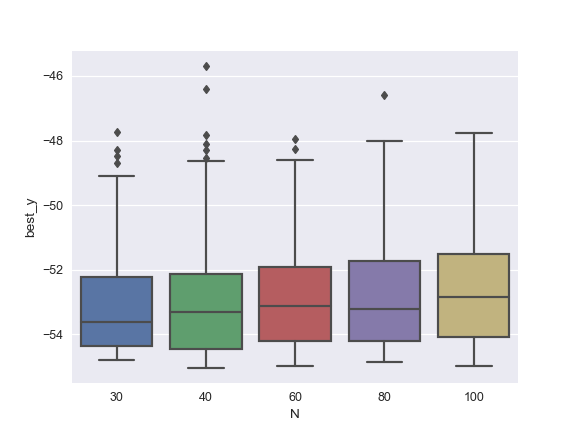

In [121]:
analyze_parameter(table_best, 'N')

#### The best DE varinat
As the best variant of differential evolution, parameters N = 30, CR = 0.5, F = 0.4  were chosen. This combination was significantly more reliable than other alternatives and achieved decent results in all other monitored metrics. However, even this option does not fully meet the original requirements.

In [123]:
best_N = 30
best_CR = 0.5
best_F = 0.4

### Optimal Strategies

In [164]:
def find_optimal_strategies():
    optimal_strategies = {'variability': [], 'best_y': [], 'best_x': []}
    for variability in tqdm(range(0, 100, 2)):
        of = DartsAvgScore(variability)
        heur = DifferentialEvolution(of, maxeval=1000, N=best_N, CR=best_CR, F=best_F)
        result = heur.search()
        optimal_strategies['variability'].append(variability)
        optimal_strategies['best_y'].append(result['best_y'])
        optimal_strategies['best_x'].append(result['best_x'])
    return optimal_strategies

In [168]:
optimal_strategies = find_optimal_strategies()


HBox(children=(FloatProgress(value=0.0, max=50.0), HTML(value='')))

In [169]:
points_for_plotter = list(map(list, zip(*optimal_strategies['best_x'])))

<IPython.core.display.Javascript object>


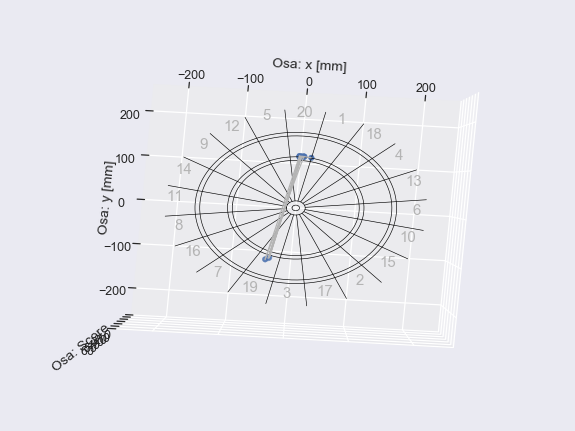

In [170]:
plotter = DartsPlotter()
plotter.plot_points(dartboard, points_for_plotter, optimal_strategies['best_y'])

#### Original Result
Optained by flock-based algorithm SPSO_2006 during the previous seminar work on MMC.
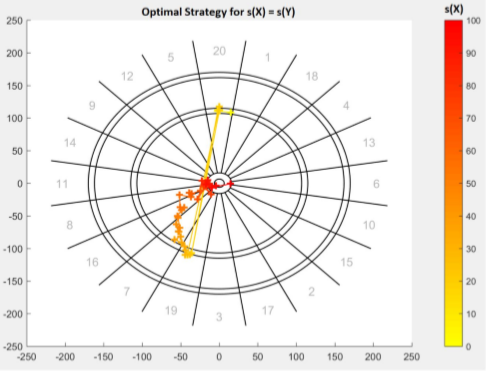

### Summary
All heuristics from this-course framework were tested on optimizing two versions of object function, standard dartboard and its smooth average-score version.

Unfortunately, no large differences in the performance of individual heuristics were observed between both object functions. Only the smooth version was more difficult to optimize, as the area of the optimal value was smaller.

The only heuristic that managed to overcome Random Shooting in both basic cases was Differential Evolution. This heuristic was then further investigated. Its reliability has been improved by 15 percent to almost 90 percent by hyper-parameter tuning. 

The best version of DE was then applied to find the optimal strategy of playing darts depending on the player's ability to hit the place he is aiming for. Heuristic was able to identify the two most important peaks, but it did not prove the correct course of the strategy, despite all efforts. Far better results were achieved by the heuristic SPSO_2006 in the original work.